In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import keras_cv

SEED = 225
# import fwr13y.d9m.tensorflow as tf_determinism
# tf_determinism.enable_determinism()
tf.keras.utils.set_random_seed(SEED)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'Tensorflow Version: {tf.__version__}')
gpus = tf.config.experimental.get_device_details(gpus[0])
print(f'Device: {gpus["device_name"]}\nCompute Capability: {gpus["compute_capability"]}')

Using TensorFlow backend


/home/ahanaf/Desktop/Tensorflow/tf_2_13_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensorflow Version: 2.13.0
Device: NVIDIA GeForce GTX 1070
Compute Capability: (6, 1)


In [2]:
IMAGE_SHAPE = (224, 224)
NUM_CLASSES = 5
BATCH_SIZE = 10
VAL_SPLIT = 0.2

train_data, val_data = keras.utils.image_dataset_from_directory(
    'flower_images', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SHAPE, 
    label_mode='categorical', 
    seed=SEED, 
    validation_split= VAL_SPLIT, 
    subset='both'
    )

Found 4999 files belonging to 5 classes.
Using 4000 files for training.
Using 999 files for validation.


In [192]:
class RandomAugmentations(keras.layers.Layer):
    def __init__(self, num_picks, image_size, seed, **kwargs):
        super().__init__(**kwargs)
        self.num_picks = num_picks
        self.image_size = image_size
        self.seed = seed
        self.first = True
        
        self.random_zoom = keras.layers.RandomZoom(
            height_factor=(-0.5, 0.5), 
            seed=seed
        )
        self.random_translation = keras.layers.RandomTranslation(
            height_factor=(-0.2, 0.2),
            width_factor=(-0.2, 0.2),
            fill_mode="reflect",
            seed=seed,
        )
        self.random_flip = keras.layers.RandomFlip(
            mode="horizontal_and_vertical", 
            seed=seed
        )
        self.random_rotate = keras.layers.RandomRotation(
            factor=0.2, 
            fill_mode="reflect", 
            seed=seed,
        )
        self.random_cutout = keras_cv.layers.RandomCutout(
            height_factor=0.4, 
            width_factor=0.4, 
            seed=seed
        )
        self.random_shear = keras_cv.layers.RandomShear(
            x_factor=0.25,
            y_factor=0.25,
            interpolation="bilinear",
            fill_mode="reflect",
            seed=seed,
        )
        self.random_channel_shift = keras_cv.layers.RandomChannelShift(
            value_range=(0, 255),
            factor=0.5,
            seed=seed,
        )
        self.gridmask = keras_cv.layers.GridMask(
            ratio_factor=(0, 0.5),
            rotation_factor=0.15,
            fill_mode="constant",
            fill_value=128,
            seed=seed,
        )
        self.random_brightness = keras.layers.RandomBrightness(
            factor=0.2, 
            value_range=(0, 255), 
            seed=seed, 
        )
        self.random_contrast = keras.layers.RandomContrast(
            factor=0.4, 
            seed=None,
        )
        self.random_color_degeneration = keras_cv.layers.RandomColorDegeneration(
            factor=0.8, 
            seed=seed,
        )
        self.grayscale = keras_cv.layers.Grayscale(
            output_channels=3,
        )
        self.histogram_equilization = keras_cv.layers.Equalization(
            value_range=(0, 255.0), 
            bins=256,
        )
        self.posterization = keras_cv.layers.Posterization(
            value_range=(0, 255.0), 
            bits=3, 
        )
        self.random_saturation = keras_cv.layers.RandomSaturation(
            factor=0.9, 
            seed=seed,
        )
        self.augmix = keras_cv.layers.AugMix(
            value_range=(0, 255.0),
            severity=0.3,
            num_chains=3,
            chain_depth=[1, 3],
            alpha=1.0,
            seed=seed,
        )
        self.mixup = keras_cv.layers.MixUp(
            alpha=0.2, 
            seed=seed,
        )
        self.cutmix = keras_cv.layers.CutMix(
            alpha=1.0, 
            seed=seed,
        )
        
        
        self.augmentation_list1 = [
            self.random_zoom, 
            self.random_translation,
            self.random_flip,
            self.random_rotate,
            self.random_cutout,
            self.random_shear,
            self.random_channel_shift,
            self.gridmask,
            self.random_brightness,
            self.random_contrast,
            self.random_color_degeneration,
            self.grayscale,
            self.histogram_equilization,
            self.posterization,
            self.random_saturation,
        ]
        
        self.augmentation_list2 = [
            self.augmix,
            self.mixup,
            self.cutmix,
        ]
        
    def call(self, inputs, labels):
        if self.first:
            self.first = False
            for _ in self.augmentation_list1:
                _(inputs)
            for _ in self.augmentation_list2:
                self.apply_augment_list2(_, inputs, labels)
                
        augments_index = self.get_augment_index()
        print(augments_index)
        for i in augments_index:
            inputs = self.augmentation_list1[i](inputs)
            
        augments_index_2 = random.sample([ x for x in range(len(self.augmentation_list2)) ], 1)
        for j in augments_index_2:
            inputs, labels = self.apply_augment_list2(self.augmentation_list2[j], inputs, labels)
        
        return inputs, labels
    
    
    def get_augment_index(self):
        return random.sample([ x for x in range(len(self.augmentation_list1)) ], self.num_picks)
    
    def apply_augment_list2(self, augment, inputs, labels):
        res = augment({'images': inputs, 'labels': labels})
        return res['images'], res['labels']

In [155]:

keras_cv.layers.RandomAugmentationPipeline

keras_cv.layers.preprocessing.rand_augment.RandAugment

In [ ]:
list1 = [ x for x in range(5) ]
random.sample(list1, 1)

[0]

In [193]:
ca = RandomAugmentations(5, 224, 224)


rc = train_data.map(lambda x, y: ca(x, y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)




ValueError: in user code:

    File "/tmp/ipykernel_16222/4118113956.py", line 4, in None  *
        lambda x, y: ca(x, y)
    File "/tmp/ipykernel_16222/2333796051.py", line 144, in __call__  *
        super().__call__(*args, **kwargs)
    File "/home/ahanaf/Desktop/Tensorflow/tf_2_13_env/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/ahanaf/Desktop/Tensorflow/tf_2_13_env/lib/python3.8/site-packages/keras/src/utils/layer_utils.py", line 969, in split_out_first_arg
        raise ValueError(

    ValueError: The first argument to `Layer.call` must always be passed.


0.0 255.0
tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)
tf.Tensor([0.         0.01060025 0.98939973 0.         0.        ], shape=(5,), dtype=float32)
tf.Tensor([0.95276225 0.         0.         0.         0.04723775], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)
tf.Tensor([0.00782164 0.         0.         0.         0.9921784 ], shape=(5,), dtype=float32)
tf.Tensor([0.         0.7042203  0.29577968 0.         0.        ], shape=(5,), dtype=float32)
tf.Tensor([0.41659886 0.         0.         0.         0.58340114], shape=(5,), dtype=float32)
tf.Tensor([0.0000000e+00 0.0000000e+00 6.5565109e-07 0.0000000e+00 9.9999934e-01], shape=(5,), dtype=float32)


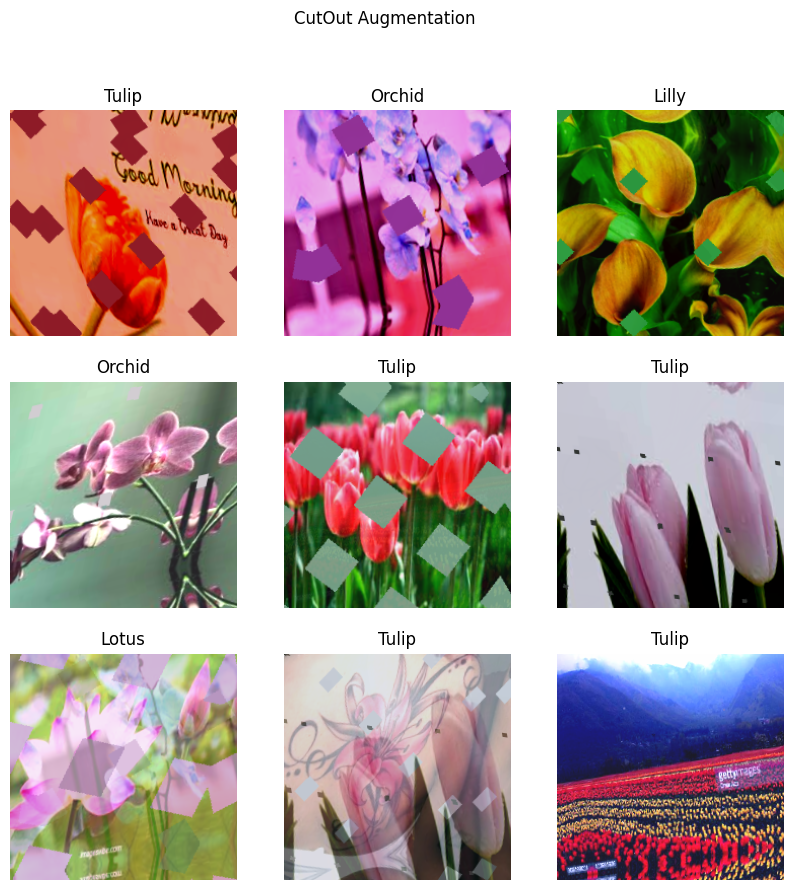

In [188]:
for x, y in rc:
    outx = x
    outy = y
    break
# augmented_images = rc(outx)
print(np.min(x), np.max(x))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(train_data.class_names[np.argmax(outy[i].numpy())])
    print(outy[i])
    plt.imshow(outx[i] / 255.0)
    plt.axis("off")
plt.suptitle('CutOut Augmentation')
plt.show()

In [22]:
import random

# List of items with weights
item_list = [
    {"item": "Item 1", "weight": 5},
    {"item": "Item 2", "weight": 3},
    {"item": "Item 3", "weight": 7},
    {"item": "Item 4", "weight": 2},
    {"item": "Item 5", "weight": 4}
]

def weighted_random_choice(items, weights, num_choices):
    total_weight = sum(weights)
    choices = random.choices(items, weights=weights, k=num_choices)
    return choices

# Extracting items and weights from the item_list
items = [item["item"] for item in item_list]
weights = [item["weight"] for item in item_list]

# Select 3 items randomly based on weights
num_choices = 3
selected_items = weighted_random_choice(items, weights, num_choices)

print("Selected items:")
for item in selected_items:
    print(item)

Selected items:
Item 5
Item 3
Item 5
